# DSC 478 Final Project: 
# Predicting whether or not a NBA player will be in the Hall Of Fame
## Matt Watson

### Introduction

For this project, I will be using a dataset from SLAM Magazine in 2011 in which they ranked the top 500 greatest NBA Players of all time to try to predict whether a player will be in the Hall of Fame or not. The data can be found here: https://www.basketball-reference.com/awards/slam_500_greatest.html.

The data contains 16 variables: Rank, Player (Name), From (first year in NBA), To (last year in NBA), G (Total Games Played), MP (average minutes per game), PTS (average points per game), TRB (average total rebounds per game), AST (average assists per game), STL (average steals per game), BLK (average blocks per game), FG% (average field goal percentage per game), 3P% (average 3 point percentage per game), FT% (average free throw percentage per game), WS (total Win Shares) and WS/48 (win shares per 48 minutes). Steals and Blocks were not recorded until the 1973 season and the 3-point line was not introduced until the 1979 season, so there are some missing values since the data includes players starting in the year 1947. I will create a "Position" variable and then convert the missing values to the median value for that position. Grouping by position makes sense, as Guards are more likely to average a higher number of steals and 3-point field goal percentage while Forwards/Centers are more likely to average a higher number of blocks. Next, I will create a new variable call "Years Played" which will be the difference between "To" and "From". Lastly, I will need to add a Hall of Fame Variable, "HoF", which will be binary with 0 representing not in the HoF and 1 representing in the HoF. In order to be eligible for the NBA Hall of Fame, you must have been retired for at least 3 full seasons. Since I downloaded this data before the 2019 season started in October, any player who is still active or retired after the 2016 season was not eligible. I will subset this data to use for predicting probabilities of entering the Hall of Fame. 

I will first run some Exploratory Data Analysis (EDA) to get some general ideas about the data. I will look at the distributions of all the variables as well as produce some Boxplots for "HoF" and a few other variables. I will then create a Logistic Regression model trying to predict "HoF" based on the other variables. I will then use this model to predict the probabilities of entering the Hall of Fame for the players who are not currently eligible. Next, I will run a K-Nearest Neighbors (KNN) model with cross validation and assign probabilities for the ineligible players. I will then run a Principal Component Analysis to decrease dimensionality. I will then run the Logistic Regression Model as well as the KNN model again using the components created from PCA.

### Packages that will be used:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing, neighbors, decomposition, model_selection
import numpy as np

### Data Cleaning

In [2]:
data = pd.read_csv("data.csv")
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
Rank      500 non-null int64
Player    500 non-null object
From      500 non-null int64
To        500 non-null int64
G         500 non-null int64
MP        500 non-null float64
PTS       500 non-null float64
TRB       500 non-null float64
AST       500 non-null float64
STL       433 non-null float64
BLK       433 non-null float64
FG%       500 non-null float64
3P%       379 non-null float64
FT%       500 non-null float64
WS        500 non-null float64
WS/48     500 non-null float64
dtypes: float64(11), int64(4), object(1)
memory usage: 62.6+ KB


,Rank,Player,From,To,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
495,496,Kevin Duckworth,1987,1997,684,25.5,11.8,5.8,0.9,0.5,0.5,0.468,0.208,0.736,24.7,0.068
496,497,Chris Kaman,2004,2016,735,26.7,11.2,7.6,1.3,0.4,1.3,0.489,0.042,0.743,24.6,0.060
497,498,Cuttino Mobley,1999,2009,747,37.0,16.0,3.9,2.7,1.2,0.4,0.433,0.378,0.835,52.2,0.091
498,499,David Wesley,1994,2007,949,31.9,12.5,2.5,4.4,1.3,0.2,0.424,0.368,0.786,61.3,0.097
499,500,Pervis Ellison,1990,2001,474,24.5,9.5,6.7,1.5,0.6,1.6,0.510,0.050,0.689,21.8,0.090


Here we can see a few things. There are 67 missing values for both "STL" and "BLK". There are also 121 missing values for "3P%". All of these missing values will be replaced with median value based on the "Position" value that will be added below. There are also 501 entries when there should only be 500. This is a result of the way the data was downloaded to a ".csv" file. The first row was skipped and the headers were in the 2nd row, so I edited the file to move the headers into the first row. I will need to delete the last row. 

In [3]:
data.drop(data.tail(1).index,inplace=True)
print(data.describe(include = 'all'))

              Rank         Player         From           To            G  \
count   499.000000            499   499.000000   499.000000   499.000000   
unique         NaN            498          NaN          NaN          NaN   
top            NaN  Eddie Johnson          NaN          NaN          NaN   
freq           NaN              2          NaN          NaN          NaN   
mean    250.000000            NaN  1980.915832  1992.545090   839.160321   
std     144.193157            NaN    14.757917    16.346139   241.805812   
min       1.000000            NaN  1947.000000  1954.000000   260.000000   
25%     125.500000            NaN  1971.000000  1980.000000   681.500000   
50%     250.000000            NaN  1982.000000  1993.000000   833.000000   
75%     374.500000            NaN  1992.000000  2005.000000   983.500000   
max     499.000000            NaN  2006.000000  2019.000000  1611.000000   

                MP         PTS         TRB         AST         STL  \
count   499.00000

After dropping the last row, we look at the distribution of all the variables. Interestingly, there are two players named "Eddie Johnson". I noticed this when I was going through the data to add the "Position" variable, and they happened to be ranked 282 and 283. I will rename the second "Eddie Johnson" as "Eddie Johnson 2".

In [4]:
data.loc[282, "Player"] = "Eddie Johnson 2"  

Below I created a list of players for each position, Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF) and Center (C) which will be used to create the "Position" variable. I got the position for each player by looking at their page on https://www.basketball-reference.com/. If the player played more than 1 position during the career, I used the position they played more season at. If they played an equal number of seasons for 2 positions, I used whichever position was listed first.

In [5]:
pg = ["Oscar Robertson", "Magic Johnson", "Jerry West", "Isiah Thomas", "John Stockton", "Bob Cousy", "Jason Kidd", "Walt Frazier", "Gary Payton", 
      "Allen Iverson", "Earl Monroe", "Steve Nash", "Tiny Archibald", "Dennis Johnson", "Dave Bing", "Hal Greer", "Lenny Wilkens", "Joe Dumars",
      "Tim Hardaway", "Sidney Moncrief", "Slater Martin","Kevin Johnson", "Chris Paul", "Norm Van Lier", "Jo Jo White", "Dick McGuire",
      "Maurice Cheeks", "Chauncey Billups", "Deron Williams", "Guy Rodgers", "Phil Chenier", "Bob Davies", "Tony Parker", "Paul Westphal",
      "Gus Williams", "Gene Shue", "Mark Price", "Calvin Murphy", "Mark Jackson", "Terry Porter", "Reggie Theus", "K.C. Jones",
      "Gilbert Arenas", "Norm Nixon", "Sam Cassell", "Stephon Marbury", "Fat Lever", "Baron Davis", "Mookie Blaylock", "Rod Strickland",
      "Derek Harper", "Steve Francis", "Quinn Buckner", "Mike Bibby", "Andre Miller", "Geoff Petrie", "John Lucas", "Terrell Brandon",
      "Sleepy Floyd", "Doc Rivers", "Larry Costello", "Phil Ford", "Nick Van Exel", "Lucius Allen", "Damon Stoudamire", "Slick Watts",
      "Kenny Anderson", "Ray Williams", "Lionel Hollins", "Kenny Smith", "Michael Adams", "Jameer Nelson", "Muggsy Bogues", "Mahmoud Abdul-Rauf",
      "Sherman Douglas", "Walt Hazzard", "Scott Skiles", "Flynn Robinson", "Derek Fisher", "Larry Drew", "Vern Fleming", "Johnny Dawkins",
      "Pooh Richardson", "Nate McMillan", "Ernie DiGregorio", "Al Attles", "B.J. Armstrong", "Spud Webb", "Kelvin Ransey", "Eric Money",
      "Jason Williams", "Devin Harris", "Jay Humphries", "Don Buse", "Wali Jones", "Dana Barros", "Avery Johnson"] 

sg = ["Michael Jordan", "Kobe Bryant", "George Gervin", "Dwyane Wade", "Reggie Miller", "Pete Maravich", "David Thompson", "Sam Jones", 
      "Bill Sharman", "Ray Allen", "Mitch Richmond", "Grant Hill", "Vince Carter", "Kevin Porter", "Richie Guerin", "Marques Johnson", 
      "Anfernee Hardaway", "Charlie Scott", "Michael Cooper", "Phil Smith", "Manu Ginóbili", "Bobby Wanzer", "Otis Birdsong", "Randy Smith", 
      "Rolando Blackman", "Andy Phillip", "Andrew Toney", "Micheal Ray Richardson", "Archie Clark", "Jimmy Walker", "Doug Collins", 
      "Alvin Robertson", "World B. Free", "Don Ohl", "Carl Braun", "Jeff Malone", "John Williamson", "Darrell Griffith", "Dale Ellis",
      "Michael Redd", "Austin Carr", "Max Zaslofsky", "Doug Christie", "Eddie Jones", "Jeff Hornacek", "Brian Winters", "Eddie Johnson",
      "Jeff Mullins", "Jerry Stackhouse", "Don Chaney", "Fred Brown", "Dick Barnett", "Dick Van Arsdale", "Danny Ainge", "Fred Carter",
      "Allan Houston", "Byron Scott", "Ron Harper", "Ben Gordon", "Vinnie Johnson", "Nick Anderson", "Paul Pressey", "Monta Ellis",
      "Steve Smith", "Ricky Sobers", "Ricky Pierce", "John Starks", "Jason Terry", "Hersey Hawkins", "Mike Newlin", "Kevin Loughery",
      "Dick Garmaker", "Vernon Maxwell", "Mike Woodson", "Johnny Davis", "Bucky Bockhorn", "Eddie Miles", "Herm Gilliam", "Adrian Smith",
      "Rex Chapman", "Jamal Crawford", "Quintin Dailey", "Jim Paxson", "Gerald Wilkins", "Dell Curry", "Kevin Martin", "Kerry Kittles",
      "Kendall Gill", "Larry Hughes", "Jon McGlocklin", "Clem Haskins", "John Long", "Šarūnas Marčiulionis", "Cuttino Mobley", "David Wesley"]

sf = ["Elgin Baylor", "Julius Erving", "John Havlicek", "Rick Barry", "Scottie Pippen", "LeBron James", "Billy Cunningham", "Clyde Drexler", 
      "Dominique Wilkins", "Dennis Rodman", "James Worthy", "Jack Twyman", "Gus Johnson", "Tom Heinsohn", "Bernard King", "Paul Arizin",
      "Dave DeBusschere", "Paul Pierce", "Alex English", "Adrian Dantley", "Cliff Hagan", "Chris Mullin", "Bob Dandridge", "Bob Love",
      "Jim Pollard", "Tracy McGrady", "Walter Davis", "Carmelo Anthony", "Jamaal Wilkes", "Chet Walker", "George Yardley", "Willie Naulls",
      "Lou Hudson", "Paul Silas", "Metta World Peace", "Shawn Marion", "Tom Gola", "Bill Bradley", "Larry Johnson", "Jerry Sloan",
      "Jamal Mashburn", "Joe Caldwell", "Mark Aguirre", "Kiki Vandeweghe", "Lamar Odom", "Kelly Tripucka", "Cedric Maxwell", "Reggie Lewis",
      "Richard Hamilton", "Peja Stojaković", "Latrell Sprewell", "Jason Richardson", "Purvis Short", "Antawn Jamison", "Jim McMillian",
      "Glenn Robinson", "Bruce Bowen", "Detlef Schrempf", "Terry Dischinger", "Toni Kukoč", "Frank Ramsey", "Anthony Mason", "Happy Hairston",
      "Shareef Abdur-Rahim", "Dan Majerle", "Jack Marin", "Clifford Robinson", "Scott Wedman", "Xavier McDaniel", "Eddie Johnson 2",
      "Cliff Robinson", "Michael Finley", "Mike Mitchell", "Glen Rice", "Calvin Natt", "Rashard Lewis", "Tom Sanders", "Sean Elliott",
      "Tom Van Arsdale", "Gerald Wallace", "Caron Butler", "Lionel Simmons", "Greg Ballard", "Danny Granger", "Andre Iguodala", "Billy Knight",
      "Jay Vincent", "Jim Jackson", "Rodney McCray", "Campy Russell", "Tayshaun Prince", "Chuck Person", "John Johnson", "Jalen Rose",
      "Mike Bantom", "Stephen Jackson", "Richard Jefferson", "Corey Maggette", "Junior Bridgeman", "M.L. Carr", "Quentin Richardson",
      "Derrick McKey", "Keith Van Horn", "Cedric Ceballos", "Michael Brooks", "Ken Norman", "Don Kojis", "Luol Deng", "Jerome Kersey",
      "Don Nelson", "Mike Miller", "Roy Hinson", "Andrei Kirilenko", "Shane Battier", "Albert King", "Josh Howard", "Hedo Türkoğlu",
      "Wally Szczerbiak", "Billy Owens", "Phil Hubbard", "Robert Reid", "Gene Banks", "Reggie Williams"]

pf = ["Larry Bird", "Bob Pettit", "Moses Malone", "Karl Malone", "Charles Barkley", "Elvin Hayes", "Kevin McHale", "Kevin Garnett", 
      "Willis Reed", "Wes Unseld", "Nate Thurmond", "Dolph Schayes", "Jerry Lucas", "Dave Cowens", "Bob McAdoo", "Dirk Nowitzki",
      "Connie Hawkins", "Joe Fulks", "Alonzo Mourning", "Chris Webber", "Dwight Howard", "Spencer Haywood", "Buck Williams",
      "Dan Issel", "George McGinnis", "Zelmo Beaty", "Tom Chambers", "Ben Wallace", "Bailey Howell", "Rudy Tomjanovich",
      "Maurice Lucas", "Amar'e Stoudemire", "Vern Mikkelsen", "Rudy LaRusso", "Terry Cummings", "Shawn Kemp", "Horace Grant",
      "Rasheed Wallace", "Bobby Jones", "Johnny Green", "John Drew", "Larry Nance", "Clyde Lovellette", "Chris Bosh", "Jermaine O'Neal",
      "Elton Brand", "Derrick Coleman", "Joe Johnson", "Larry Kenon", "Bill Bridges", "Alvan Adams", "Carlos Boozer", "Marcus Camby",
      "Danny Manning", "Charles Oakley", "Sidney Wicks", "Ray Scott", "Cazzie Russell", "Mickey Johnson", "Orlando Woolridge",
      "Clark Kellogg", "Antoine Walker", "Truck Robinson", "A.C. Green", "Ralph Sampson", "David West", "Dan Roundfield", "Otis Thorpe",
      "Zach Randolph", "Bob Boozer", "Kenny Sears", "Tom Gugliotta", "Kenyon Martin", "Sam Perkins", "Tom Meschery", "Wayman Tisdale",
      "Luke Jackson", "Kevin Willis", "Roy Tarpley", "Vin Baker", "Nat Clifton", "Robert Horry", "Armen Gilliam", "John Shumate",
      "Antonio McDyess", "Juwan Howard", "Lloyd Neal", "Lonnie Shelton", "Larry Smith", "Woody Sauldsberry", "Jim Washington",
      "Kermit Washington", "Antonio Davis", "Christian Laettner", "Thurl Bailey", "Al Harrington", "Kenny Carr", "Ron Behagen",
      "Brian Grant", "Tyrone Hill", "Troy Murphy", "Curtis Rowe", "Dave Greenwood", "Charles Smith", "David Lee", "Grant Long",
      "LaPhonso Ellis", "Gar Heard", "Terry Catledge", "Bob Kauffman", "Loy Vaught", "Mitch Kupchak", "Joe Graboski", "Antoine Carr",
      "Joe Smith", "P.J. Brown", "Drew Gooden"]

c = ["Wilt Chamberlain", "Bill Russell", "Shaquille O'Neal", "Kareem Abdul-Jabbar", "Tim Duncan", "Hakeem Olajuwon", "David Robinson", 
     "George Mikan", "Patrick Ewing", "Walt Bellamy", "Bob Lanier", "Robert Parish", "Bill Walton", "Neil Johnston", "Ed Macauley",
     "Artis Gilmore", "Dikembe Mutombo", "Pau Gasol", "Brad Daugherty", "Jack Sikma", "Harry Gallatin", "Larry Foust", "Red Kerr",
     "Yao Ming", "Bob Rule", "Wayne Embry", "Arnie Risen", "Bill Laimbeer", "Jeff Ruland", "Walter Dukes", "Zydrunas Ilgauskas",
     "Rony Seikaly", "Caldwell Jones", "Rik Smits", "Vlade Divac", "Bill Cartwright", "Mel Hutchins", "Swen Nater", "Sam Lacey",
     "Elmore Smith", "Joe Barry Carroll", "Theo Ratliff", "Arvydas Sabonis", "Jim Chones", "Darryl Dawkins", "Al Jefferson",
     "Steve Stipanovich", "Mark Eaton", "Mychal Thompson", "Ray Felix", "Steve Johnson", "Michael Cage", "Dale Davis", "Andrew Bogut",
     "James Edwards", "Hot Rod Williams", "Sam Bowie", "Zaid Abdul-Aziz", "Emeka Okafor", "Tree Rollins", "Marvin Webster",
     "Elden Campbell", "Clyde Lee", "Clifford Ray", "Manute Bol", "Kevin Duckworth", "Chris Kaman", "Pervis Ellison"]

In [6]:
def pos(row):
    if row['Player'] in pg:
        val = "PG"
    elif row['Player'] in sg:
        val = "SG"
    elif row['Player'] in sf:
        val = "SF"
    elif row['Player'] in pf:
        val = "PF"
    elif row['Player'] in c:
        val = "C"
    else:
        val = ""
    return val

data['Position'] = data.apply(pos, axis = 1)

data.tail()

,Rank,Player,From,To,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Position
494,495,Drew Gooden,2003,2016,790,25.5,11.0,7.1,1.1,0.7,0.6,0.462,0.257,0.760,43.9,0.105,PF
495,496,Kevin Duckworth,1987,1997,684,25.5,11.8,5.8,0.9,0.5,0.5,0.468,0.208,0.736,24.7,0.068,C
496,497,Chris Kaman,2004,2016,735,26.7,11.2,7.6,1.3,0.4,1.3,0.489,0.042,0.743,24.6,0.060,C
497,498,Cuttino Mobley,1999,2009,747,37.0,16.0,3.9,2.7,1.2,0.4,0.433,0.378,0.835,52.2,0.091,SG
498,499,David Wesley,1994,2007,949,31.9,12.5,2.5,4.4,1.3,0.2,0.424,0.368,0.786,61.3,0.097,SG


I created the function pos(row) to add the "Position" variable to the data. We can see that it somehow missed the last player, "Pervis Ellison," so I will need to add his position manually.

In [7]:
data.loc[499, "Position"] = "C"

print(data.tail())

data['Position'].value_counts()

      Rank           Player    From      To      G    MP   PTS  TRB  AST  STL  \
495  496.0  Kevin Duckworth  1987.0  1997.0  684.0  25.5  11.8  5.8  0.9  0.5   
496  497.0      Chris Kaman  2004.0  2016.0  735.0  26.7  11.2  7.6  1.3  0.4   
497  498.0   Cuttino Mobley  1999.0  2009.0  747.0  37.0  16.0  3.9  2.7  1.2   
498  499.0     David Wesley  1994.0  2007.0  949.0  31.9  12.5  2.5  4.4  1.3   
499    NaN              NaN     NaN     NaN    NaN   NaN   NaN  NaN  NaN  NaN   

     BLK    FG%    3P%    FT%    WS  WS/48 Position  
495  0.5  0.468  0.208  0.736  24.7  0.068        C  
496  1.3  0.489  0.042  0.743  24.6  0.060        C  
497  0.4  0.433  0.378  0.835  52.2  0.091       SG  
498  0.2  0.424  0.368  0.786  61.3  0.097       SG  
499  NaN    NaN    NaN    NaN   NaN    NaN        C  


SF    123
PF    117
PG     97
SG     95
C      68
Name: Position, dtype: int64

Now that I have the "Position" variable created, I can replace the missing values with the median of the position.

In [8]:
data['STL'] = data.groupby('Position')['STL'].transform(lambda x: x.fillna(x.median()))

data['BLK'] = data.groupby('Position')['BLK'].transform(lambda x: x.fillna(x.median()))

data['3P%'] = data.groupby('Position')['3P%'].transform(lambda x: x.fillna(x.median()))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 17 columns):
Rank        499 non-null float64
Player      499 non-null object
From        499 non-null float64
To          499 non-null float64
G           499 non-null float64
MP          499 non-null float64
PTS         499 non-null float64
TRB         499 non-null float64
AST         499 non-null float64
STL         500 non-null float64
BLK         500 non-null float64
FG%         499 non-null float64
3P%         500 non-null float64
FT%         499 non-null float64
WS          499 non-null float64
WS/48       499 non-null float64
Position    500 non-null object
dtypes: float64(15), object(2)
memory usage: 90.3+ KB


In the above output, we can see that there are no more missing values. Next, I will be creating the "HoF" variable. 

In [9]:
hof = ["George Mikan", "Ed Macauley", "Andy Phillip", "Bob Davies", "Bob Pettit", "Bob Cousy", "Dolph Schayes", "Bill Russell", "Tom Gola",
       "Bill Sharman", "Elgin Baylor", "Paul Arizin", "Joe Fulks", "Cliff Hagan", "Jim Pollard", "Wilt Chamberlain", "Jerry Lucas", 
       "Oscar Robertson", "Jerry West", "Hal Greer", "Slater Martin", "Frank Ramsey", "Willis Reed", "Bill Bradley", "Dave DeBusschere",
       "Jack Twyman", "John Havlicek", "Sam Jones", "Al Cervi", "Nate Thurmond", "Billy Cunningham", "Tom Heinsohn", "Rick Barry",
       "Walt Frazier", "Bob Houbregs", "Pete Maravich", "Bobby Wanzer", "Clyde Lovellette", "Wes Unseld", "K.C. Jones", "Lenny Wilkins",
       "Dave Bing", "Dave Cowens", "Harry Gallatin", "Connie Hawkins", "Bob Lanier", "Walt Bellamy", "Julius Erving", "Dan Issel",
       "Dick McGuire", "Calvin Murphy", "Bill Walton", "Buddy Jeannette", "Kareem Abdul-Jabbar", "Vern Mikkelsen", "George Gervin",
       "Gail Goodrich", "David Thompson", "George Yardley", "Alex English", "Bailey Howell", "Larry Bird", "Arnie Risen", "Wayne Embry",
       "Kevin McHale", "Bob McAdoo", "Isiah Thomas", "Moses Malone", "Magic Johnson", "Drazen Petrovic", "Earl Lloyd", "Robert Parish",
       "James Worthy", "Clyde Drexler", "Maurice Stokes", "Charles Barkley", "Joe Dumars", "Dominique Wilkins", "Adrian Dantley", 
       "Patrick Ewing", "Hakeem Olajuwon", "Michael Jordan", "David Robinson", "John Stockton", "Dennis Johnson", "Gus Johnson",
       "Karl Malone", "Scottie Pippen", "Artis Gilmore", "Chris Mullin", "Dennis Rodman", "Arvydas Sabonis", "Tom Sanders", "Don Barksdale",
       "Mel Daniels", "Reggie Miller", "Ralph Sampson", "Chet Walker", "Jamaal Wilkes", "Richie Guerin", "Bernard King", "Gary Payton",
       "Nathaniel Clifton", "Slick Leonard", "Sarunas Marciulionis", "Alonso Mourning", "Mitch Richmond", "Guy Rodgers", "Louis Dampier",
       "Spencer Haywood", "Tom Heinsohn", "Dikembe Mutombo", "Jo Jo White", "Zelmo Beaty", "Allen Iverson", "Yao Ming", "Shaquille O'Neal",
       "George McGinnis", "Tracy McGrady", "Ray Allen", "Maruice Cheeks", "Grant Hill", "Jason Kidd", "Steve Nash", "Dino Radja", 
       "Charlie Scott", "Rod Thorn", "Carl Braun", "Chuck Cooper", "Vlade Divac", "Bobby Jones", "Sidney Moncrief", "Jack Sikma", "Paul Wetphal"]

def hf(row):
    if row['Player'] in hof:
        val = 1
    else:
        val = 0 
    return val

data['HoF'] = data.apply(hf, axis = 1)

data['HoF'] = pd.Categorical(data.HoF)

I used: https://www.landofbasketball.com/hall_of_fame/hall_of_famers_by_year.htm to create a list of all NBA players in the Hall of Fame. The function hf(row) was created, similar to pos(row) to add the "HoF" to the data. I then needed to convert it to a categorical variable. 

In [10]:
data['HoF'].value_counts()

0    387
1    113
Name: HoF, dtype: int64

In [11]:
len(hof)

134

Of the 500 players in the data, only 113 are in the Hall of Fame. However, there are a total of 134 players in the Hall of Fame. It is interesting that SLAM magazine did not include 21 Hall of Famers in their top 500 player list. The last step in my data cleaning is to add the "Years Played" variable, which I will do below. 

In [12]:
data['Years Played'] = data['To'] - data['From']

### Exploratory Data Analysis

In [31]:
print(data.describe(include = 'all'))

              Rank        Player         From           To            G  \
count   499.000000           499   499.000000   499.000000   499.000000   
unique         NaN           499          NaN          NaN          NaN   
top            NaN  Walter Dukes          NaN          NaN          NaN   
freq           NaN             1          NaN          NaN          NaN   
mean    250.000000           NaN  1980.915832  1992.545090   839.160321   
std     144.193157           NaN    14.757917    16.346139   241.805812   
min       1.000000           NaN  1947.000000  1954.000000   260.000000   
25%     125.500000           NaN  1971.000000  1980.000000   681.500000   
50%     250.000000           NaN  1982.000000  1993.000000   833.000000   
75%     374.500000           NaN  1992.000000  2005.000000   983.500000   
max     499.000000           NaN  2006.000000  2019.000000  1611.000000   

                MP         PTS         TRB         AST         STL  \
count   499.000000  499.00000

The median value for "From" is 1980, the min is 1947 and the max is 2006. The median value for "To" is 1982, the min is 1954 and the max is 2006. More than 75% of the players in the data had their whole career before I was born in 1996. The median value for "G" is 832.5, the min is 260 and the max is 1611. The median value of "MP" is 30.6, the min is 18.7 and the max is 45.8. An NBA game is 48 minutes long, so it is impressive that there is player who averaged almost 46 minutes per game throughout his career. The median value for "PTS" is 14.3, the min is 2.6 and the max is 30.1. The player who only scored 2.6 games in his career must've average a high number of Rebound/Assist/Steals/Blocks in order to be included in this list. The median value for "TRB" is 5.5, the min is 1.7 and the max is 22.9. This big difference in average rebounds per game shows why grouping by position when filling the missing values is important. The median value for "AST" is 2.75, the min is 0.3 and the max is 11.2. The median value for "STL" is 1, the min 0.2 and the max is 2.7. The median value for "BLK" is 0.4, the min is 0.0 and the max is 3.5. The median value for "FG%" is 0.4635, the min is 0.302 and the max is 0.599. Every player in the data at least average 30% throughout their career. The median value for "3P%" is 0.3025, the min is 0.00 and the max is 1.00. The median value for "FT%" is 0.769, the min is 0.414 and the max is 0.905. The median value for "WS" is 58.65, the min is -7.9 and the max is 273.4. The median value for "WS/48" is 0.1155, the min is -0.045 and the max is 0.25. Of the 500 players in the data, the most common position is "SF" with a count of 123. 387 out of the 500 players are not in the Hall of Fame, although some of these players are not eligible yet. The median value for "Years Played" is 12, the min is 4 and the max is 22.

Next, I will remove the players who are not eligible for the Hall of Fame and then create some boxplots. 

In [14]:
data_sub = data[data["To"] > 2015]

data_naoi = data[~data.isin(data_sub)].dropna()

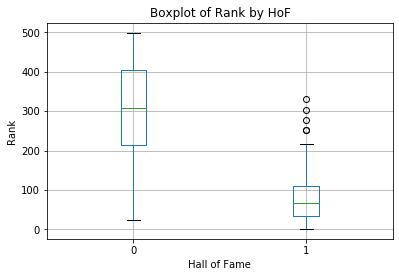

In [15]:
%matplotlib inline
data_naoi.boxplot(column = 'Rank', by = 'HoF')
plt.title("Boxplot of Rank by HoF")
plt.suptitle("")
plt.xlabel("Hall of Fame")
plt.ylabel("Rank")
plt.show()

We can see that most of the players (around 75%) that are in the Hall of Fame are ranked in the top 100, besides 4 outliers.

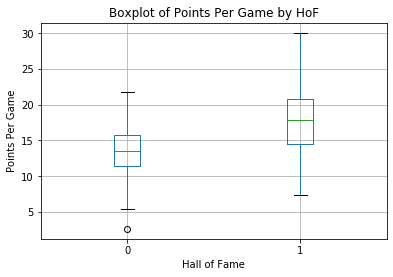

In [16]:
%matplotlib inline
data_naoi.boxplot(column = 'PTS', by = 'HoF')
plt.title("Boxplot of Points Per Game by HoF")
plt.suptitle("")
plt.xlabel("Hall of Fame")
plt.ylabel("Points Per Game")
plt.show()

We can that most of the players (around 75%) that are in the Hall of Fame averaged more than 15 points per game throughout their careers. The players not in the Hall of Fame tended to average between 10 and 15 points.

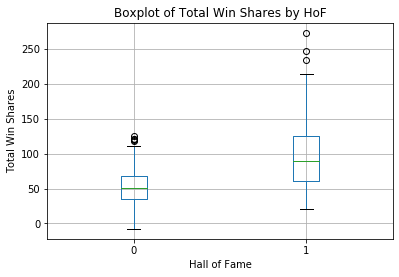

In [17]:
%matplotlib inline
data_naoi.boxplot(column = 'WS', by = 'HoF')
plt.title("Boxplot of Total Win Shares by HoF")
plt.suptitle("")
plt.xlabel("Hall of Fame")
plt.ylabel("Total Win Shares")
plt.show()

Here we can see that players in the Hall of Fame had more Win Shares than players who are not in the Hall of Fame. 

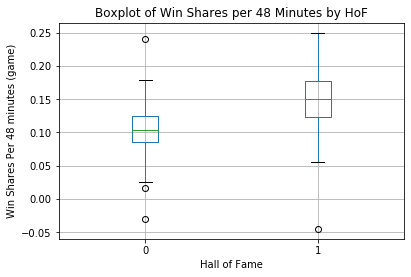

In [18]:
%matplotlib inline
data_naoi.boxplot(column = 'WS/48', by = 'HoF')
plt.title("Boxplot of Win Shares per 48 Minutes by HoF")
plt.suptitle("")
plt.xlabel("Hall of Fame")
plt.ylabel("Win Shares Per 48 minutes (game)")
plt.show()

Here we can see that players in the Hall of Fame averaged a higher Win Shares Per 48 minutes than players who are not in the Hall of Fame. There is one outlier for players in the Hall of Fame, however. 

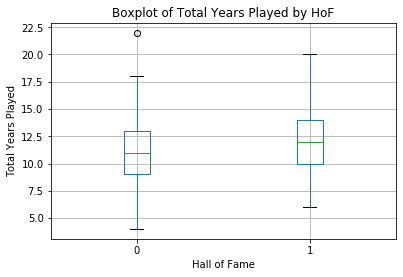

In [19]:
%matplotlib inline
data_naoi.boxplot(column = 'Years Played', by = 'HoF')
plt.title("Boxplot of Total Years Played by HoF")
plt.suptitle("")
plt.xlabel("Hall of Fame")
plt.ylabel("Total Years Played")
plt.show()

Here we can see that there is not that big of a difference for Total Years Played for Players who are in the Hall of Fame versus those who are not.

### Logistic Regression

In order to perform Logistic Regression (using LogisticRegression from sklearn), I will first need to pre-process the data some more. I will create a subset called "Validate," which will include all the players who are not eligible for the Hall of Fame. I will also need to separate the target variable, "Hof", and remove categorical variables "Player" and "Position."

In [20]:
validate = data_sub.drop(['HoF', 'Position'], axis = 1)

y = data_naoi['HoF']

data_naoi = data_naoi.drop(['HoF', 'Position', 'Player'], axis = 1)

Next, I will split the data into training and testing spits using a 0.2 split (80% of the data will be in the training and 20% in testing). After that, the data will be ready to be used in Logistic Regression.

In [21]:
nba_train, nba_test, hof_train, hof_test = train_test_split(data_naoi, y, test_size=0.2, random_state=33)

In [22]:
lr = LogisticRegression()

lr.fit(nba_train, hof_train)

C:\Users\MWatson717\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
col = list(data_naoi.columns)
coef = lr.coef_
for i in range(len(col)):
    print("{}: {:0.3f}".format(col[i], coef[0, i]))
print("\n")
print(lr.intercept_)

Rank: -0.027
From: 0.051
To: -0.045
G: -0.003
MP: -0.159
PTS: -0.084
TRB: 0.074
AST: -0.050
STL: -0.002
BLK: -0.013
FG%: -0.015
3P%: 0.007
FT%: 0.007
WS: 0.035
WS/48: -0.001
Years Played: -0.096


[0.00259366]


In the above output, we first see the coefficients for each of the variables. IT looks like "TRB" has the largest positive impact on predicting HOF with a value of 0.081, while "Years Played" has the largest negative impact with a value of -0.097. The last value, 0.00366024, is the intercept. Next, I will use the test data to create a confusion matrix so we can see how the model performed. 

In [24]:
y_pred = lr.predict(nba_test)

lr_cm = confusion_matrix(hof_test, y_pred)
print(lr_cm)

[[71  4]
 [ 2 15]]


The model accurately predicted 71 "0s", misclassified 4 "0s" as "1s", misclassified 7 "1s" as "0s" and accurately predicted 15 "1s".

In [25]:
acc = (lr_cm[0,0] + lr_cm[1,1]) / (lr_cm[0,0] + lr_cm[0,1] + lr_cm[1,0]+ lr_cm[1,1])
print("The Overall Accuracy is: {:0.2f}%".format(acc*100))

The Overall Accuracy is: 93.48%


This model performed quite well, as it accurately predicted over 93% of observations in the testing data. Next, I will compute predicted probabilities of entering the Hall of Fame for the currently ineligible players (saved in the datafarme "validate").

In [26]:
players = list(validate['Player'])
validate_nn = validate.drop('Player', axis = 1)
probs = lr.predict_proba(validate_nn)

print("Probability of joining hall of fame: ")
for i in range(len(validate_nn)):
    print("{}: {:0.3f}%".format(players[i], probs[i, 1]*100))

Probability of joining hall of fame: 
Tim Duncan: 99.296%
Kobe Bryant: 91.735%
Kevin Garnett: 96.261%
LeBron James: 98.635%
Dwyane Wade: 83.804%
Dirk Nowitzki: 93.575%
Paul Pierce: 69.493%
Dwight Howard: 89.785%
Pau Gasol: 78.208%
Vince Carter: 33.875%
Carmelo Anthony: 31.283%
Chris Paul: 91.678%
Deron Williams: 37.197%
Tony Parker: 24.898%
Metta World Peace: 14.747%
Manu Ginóbili: 66.832%
Amar'e Stoudemire: 55.978%
Chris Bosh: 31.278%
Elton Brand: 22.258%
Joe Johnson: 2.268%
Andre Miller: 1.228%
David West: 4.199%
Zach Randolph: 0.943%
Caron Butler: 0.209%
Andre Iguodala: 0.295%
Jameer Nelson: 0.204%
Al Jefferson: 0.413%
Monta Ellis: 0.043%
Tayshaun Prince: 0.124%
Richard Jefferson: 0.069%
Jason Terry: 0.028%
Andrew Bogut: 0.123%
Luol Deng: 0.023%
Mike Miller: 0.019%
Jamal Crawford: 0.002%
Emeka Okafor: 0.030%
Kevin Martin: 0.020%
David Lee: 0.050%
Devin Harris: 0.013%
Drew Gooden: 0.011%
Chris Kaman: 0.006%


These results look accurate in my opinion. Players such as Tim Duncan, Kobe Bryant, Kevin Garnett, Lebron James, Dwyane Wade, Dirk Nowitzki and Chris Paul are all very well-known and have many NBA Finals appearances. It would be hard to argue that any of these players do not belong in the Hall of Fame. This model gives all these players greater than a 90% chance of being in the Hall of Fame.

The Logistic Regression Model gave me surprisingly good results. I had believed that things such as MVP, finals appearances, All Star, etc. would be greatly important in determining whether a player would be in Hall of Fame. This does not seem to be the case, however, as the model was able to accurately predict over 90% of the test data and gave reasonable probabilities for currently active or not yet eligible players to be in the hall of Fame. Let's see how a KNN model will perform.

### K-Nearest Neighbors

Now I will run a K-Nearest Neighbors (KNN) model. I will again need to do some preprocessing of the data. I need to remove the "Player" variable, convert "Position" to dummy variables and then normalize the data.

In [27]:
data_norm = data.drop(['Player', 'HoF'], axis = 1)

data_norm = pd.get_dummies(data_norm, columns = ['Position'])

min_max_scaler = preprocessing.MinMaxScaler().fit(data_norm)
data_norm = min_max_scaler.transform(data_norm)

Now I need to remove the ineligible players from the data. Since the data is an array now, I need to select the indexes for both and columns to remove.

In [28]:
validate

,Rank,Player,From,To,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Years Played
7,8.0,Tim Duncan,1998.0,2016.0,1392.0,34.0,19.0,10.8,3.0,0.7,2.2,0.506,0.179,0.696,206.4,0.209,18.0
9,10.0,Kobe Bryant,1997.0,2016.0,1346.0,36.1,25.0,5.2,4.7,1.4,0.5,0.447,0.329,0.837,172.7,0.170,19.0
29,30.0,Kevin Garnett,1996.0,2016.0,1462.0,34.5,17.8,10.0,3.7,1.3,1.4,0.497,0.275,0.789,191.4,0.182,20.0
30,31.0,LeBron James,2004.0,2019.0,1198.0,38.6,27.2,7.4,7.2,1.6,0.8,0.504,0.343,0.736,226.6,0.235,15.0
48,49.0,Dwyane Wade,2004.0,2019.0,1054.0,33.9,22.0,4.7,5.4,1.5,0.8,0.480,0.293,0.765,120.7,0.162,15.0
54,55.0,Dirk Nowitzki,1999.0,2019.0,1522.0,33.8,20.7,7.5,2.4,0.8,0.8,0.471,0.380,0.879,206.3,0.193,20.0
76,77.0,Paul Pierce,1999.0,2017.0,1343.0,34.2,19.7,5.6,3.5,1.3,0.6,0.445,0.368,0.806,150.0,0.157,18.0
85,86.0,Dwight Howard,2005.0,2019.0,1044.0,34.5,17.4,12.6,1.5,0.9,2.0,0.583,0.095,0.567,128.9,0.172,14.0
95,96.0,Pau Gasol,2002.0,2019.0,1226.0,33.4,17.0,9.2,3.2,0.5,1.6,0.507,0.368,0.753,144.1,0.169,17.0
98,99.0,Vince Carter,1999.0,2019.0,1481.0,30.7,17.2,4.4,3.2,1.0,0.6,0.437,0.374,0.798,125.5,0.132,20.0


The first column is the index I will need to use for the rows, and I will also need to specify that I will be removing all the columns for these rows. 

In [29]:
row_ix = np.array([7, 9, 29, 30, 48, 54, 76, 85, 95, 98, 104, 106, 127, 138, 139, 142, 143, 170, 176, 183, 254, 
                   260, 272, 323, 332, 345, 346, 352, 356, 375, 379, 413, 417, 430, 439, 451, 454, 457, 460, 494, 496])
    
col_ix = np.array([0, 1, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

val = data_norm[row_ix[:, None], col_ix]

data_norm = np.delete(data_norm, row_ix, 0)

"val" is the array containing the data for the ineligible players. I dropped this data from "data_norm". Next, I will create a train/test split of the data. 

In [30]:
nba_train, nba_test, hof_train, hof_test = train_test_split(data_norm, y, test_size=0.2, random_state=33)

ValueError: Found input variables with inconsistent numbers of samples: [459, 458]

Below is function called "kNN" that will compare the results of k=1 to k=10

In [ ]:
def kNN(x_train, y_train, x_test, y_test):
    for i in range(1,11):
        knnclf = neighbors.KNeighborsClassifier(i)
        knnclf.fit(x_train, y_train)
        knnpreds_test = knnclf.predict(x_test)
        print("Results for {} neighbors: ".format(i))
        print("Classification Report:")
        print(classification_report(y_test, knnpreds_test))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, knnpreds_test))
        print("\n")

In [ ]:
kNN(nba_train, hof_train, nba_test, hof_test)

k = 5 and k = 9 both gave the best results, misclassifying only 7 out of 92 in the test data. However, k = 5 did better at predicting "1s", or players that are in the Hall of Fame, so I will fit a new model with that value. I will display the confusion matrix, compute the scores on training on testign and perform cross validation.

In [ ]:
knnclf = neighbors.KNeighborsClassifier(5)
knnclf.fit(nba_train, hof_train)

knnpreds_test = knnclf.predict(nba_test)
knncm = confusion_matrix(hof_test, knnpreds_test)
print(knncm)

In [ ]:
%matplotlib inline
plt.matshow(knncm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Above is a plot showing the results of the confusion matrix. It might look like the model performed poorly on predicting "1s," but there are only a few players in the Hall of Fame in the testing data. 

In [ ]:
print ("Score on Training: ", knnclf.score(nba_train, hof_train))
print ("Score on Test: ", knnclf.score(nba_test, hof_test))

The model performed slightly better on the Test Data than on the Training, which is a good sign that there is no overfitting.

In [ ]:
cv_scores = model_selection.cross_val_score(knnclf, nba_train, hof_train, cv = 5)
print(cv_scores)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

The accuracy on Cross Validation gave similar results as the model without cross validation. So, it looks like the KNN model can accurately predict roughly 0.87 of the cases in the test data. Now I will compute predicted probabilities for the ineligible players.

In [ ]:
probs = knnclf.predict_proba(val)
print("Probability of joining hall of fame: ")
for i in range(len(validate_nn)):
    print("{}: {}%".format(players[i], probs[i, 1]*100))

The KNN model gave us different results for the predicted probabilities. The probabilities are only 0%, 20%, 40%, 60%, 80% and 100%. Regardless of that, it performed fairly accurately. The players I would expect to be in the Hall of Fame, such as Tim Duncan, Kobe Bryant, Lebron James and Dwyane Wade all got probabilities of 80% or greater. 

Next, I will run PCA to attempt to reduce dimensionality, and then I will refit both the Logistic Regression Model and the KNN model on the new data. 

### Principal Component Analysis (PCA)

The goal of PCA is to reduce the dimensionality of the data. Since there are only 20 some variables in the data after normalization, the size of the data is not too big of an issue. Regardless, I will perform PCA and then see if the results for Logistic Regression and KNN differ. I will need to run two different PCA models, one for the non-normalized data for Logistic Regression and one for the normalized data for KNN.

In [ ]:
pca = decomposition.PCA(n_components = 10)

pca.fit_transform(data_naoi)

var = pca.explained_variance_ratio_
print(var)
var[0] + var[1]

For the non-normalized data, we can use only 2 components, as they explain over 99% of the variance in the data. 

In [ ]:
pca = decomposition.PCA(n_components = 2)
naoi2 = pca.fit_transform(data_naoi)
validate_nn2 = pca.fit_transform(validate_nn)

"naoi2" is the new data created using 2 components to be used for Logistic Regression. 

In [ ]:
pca = decomposition.PCA(n_components = 10)

pca.fit_transform(data_norm)

var = pca.explained_variance_ratio_
print(var)
sum(var)

For the normalized data, I need to use 10 components in order to explain 95% of the variance.

In [ ]:
pca = decomposition.PCA(n_components = 10)
data2 = pca.fit_transform(data_norm)   
val2 = pca.fit_transform(val)

"data2" is the new data created using 10 components to be used for KNN. 

### Logistic Regression on PCA Components 

I will now repeat all of the steps in the original Logistic Regression section on the PCA data.

In [ ]:
nba_train, nba_test, hof_train, hof_test = train_test_split(naoi2, y, test_size=0.2, random_state=33)

In [ ]:
lr = LogisticRegression()

lr.fit(nba_train, hof_train)

In [ ]:
coef = lr.coef_

for i in range(2):
    print("Component {}: {:0.3f}".format(i, coef[0, i]))
print("\n")
print(lr.intercept_)

Above we see the coefficients for each of the components and then the intercept. It looks like component 2 has a larger impact on the model.

In [ ]:
y_pred = lr.predict(nba_test)

lr_cm = confusion_matrix(hof_test, y_pred)
print(lr_cm)

Above is the confusion matrix. We can see that the model accurately predicted 86 out of the 92 of the observations in the testing data. 

In [ ]:
acc = (lr_cm[0,0] + lr_cm[1,1]) / (lr_cm[0,0] + lr_cm[0,1] + lr_cm[1,0]+ lr_cm[1,1])
print("The Overall Accuracy is: {:0.2f}%".format(acc*100))

I got the same Overall Accuracy on this model as the original Logistic Regression Model, however the Original model performed better at classifying "1s," as it only misclassified 2 observations compared to 3 in this model.

In [ ]:
probs = lr.predict_proba(validate_nn2)

print("Probability of joining hall of fame: ")
for i in range(len(validate_nn)):
    print("{}: {:0.3f}%".format(players[i], probs[i, 1]*100))

Besides Dirk Nowitzki and Vince Carter having high probabilities, these results do not make very much sense. It might be because I transformed the data (data_naoi) and the ineligible players (validate_nn) separately. They are transformed on the same PCA model, so maybe this model just performs poorly on predicting these players.

### KNN on PCA Components 

I will now repeat all of the steps in the original KNN on section on the PCA data.

In [ ]:
nba_train, nba_test, hof_train, hof_test = train_test_split(data2, y, test_size=0.2, random_state=33)

kNN(nba_train, hof_train, nba_test, hof_test)

k = 1 and k =2 both only misclassified 6 out of the 92 observations in the testing data. However, k = 1 performed better at classifying "1s," so I will create a model with k = 1, report the confusion matrix, the scores on training and testing and perform cross validation.

In [ ]:
knnclf = neighbors.KNeighborsClassifier(1)
knnclf.fit(nba_train, hof_train)

knnpreds_test = knnclf.predict(nba_test)
knncm = confusion_matrix(hof_test, knnpreds_test)
print(knncm)

In [ ]:
%matplotlib inline
plt.matshow(knncm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print ("Score on Training: ", knnclf.score(nba_train, hof_train))
print ("Score on Test: ", knnclf.score(nba_test, hof_test))

The score on the test data is slightly higher than the score from the original KNN model (0.924). However, the score on the training data is 1.0 here, maybe implying an issue with overfitting.

In [ ]:
cv_scores = model_selection.cross_val_score(knnclf, nba_train, hof_train, cv = 5)
print(cv_scores)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

The original KNN model gave us an accuracy on cross validation of 0.87 +/- 0.4, so this model performed slighlty worse. 

In [ ]:
probs = knnclf.predict_proba(val2)
print("Probability of joining hall of fame: ")
for i in range(len(validate_nn)):
    print("{}: {}%".format(players[i], probs[i, 1]*100))

These predicted probabilities make no sense. It might be because I transformed the data (data_norm) and the ineligible players (val) separately. They are transformed on the same PCA model, so maybe this model just performs poorly on predicting these players.

### Discussion / Future Work

Overall, all the models performed much better than I expected. I believed that things such as number of Finals won, number of All-Star Games, number of MVPS won and other metrics outside of game stats were of high importance when considering whether to vote a player into the Hall of Fame. This does not seem to be the case, however. The original Logistic Regression model gave an accuracy of 93.48% and performed quite well when predicting probabilities of active/players who have not been retired for 3 seasons entering the Hall of Fame. After running PCA on the data and refitting the Logistic Regression model on the component data, I got the same accuracy as before running PCA. However, the predicted probabilities made no sense with this model. The KNN Model performed quite well also, with a score on Cross Validation of 0.87 +/- 0.4 using k = 5. I tested k=1 to k=10, and the worst model of those still accurately predicted 80 out of the 92 observations in the testing data. The score on the test data was slightly higher than the score on the training data, with both being greater than 0.915. This model gave fairly accurate predictions for players not eligible for the Hall of Fame as well. After running PCA on the data and refitting the KNN model on the component data, I got similar results. Using k=1 to k=10, the worst model accurately predicted 83 out of the 92 observations in the test data. K = 1 was determined to be the best model, and a cross validation on this model gave us a score of 0.85 +/- 0.5, which is only slightly worse than the original KNN model. This model performed poorly on predicted probabilities of entering the Hall of Fame for currently ineligible players, however. 

All of the models I created gave accuracy scores between 85% and 93.48%, which is far better than I expected. The only major issue I ran into is that both the Logistic Regression and KNN models performed very poorly when used to predict probabilities of entering the Hall of Fame for currently ineligible players. As I stated above, this might be because the data were transformed separately, but since they were transformed on the same PCA model, I would assume that this would not create an issue.

There are a few things I could change if I were to continue to work on this project. First, I could add things such as MVP, Finals appearances, etc. to the model to see how it affects performance. This would require lots of manual data entry or to write a web scraping function to get this information on various accolades from the internet. This was outside of the scope of this course and would require lots of hours spent on it. I could also add more retired players in the dataset as well, which could be done manually or by web scraping as well. I could also create more models, such as Naive Bayes and K-Means clustering and compare the results to those obtained in this project

### Appendix

#### List of files included in this project:

Final Project.ipynb (this file)

FinalProject.html

summary.docx  (Executive Summary)

final.py (contains all of the code used)

nba.csv (data used)


#### Links to various resources used:

https://www.basketball-reference.com/awards/slam_500_greatest.html (where I got the original data from)

https://www.basketball-reference.com/ (used to find the position for each player)

https://www.landofbasketball.com/hall_of_fame/hall_of_famers_by_year.htm (used to create list of players in Hall of Fame)


#### List of all Packages used is included right after the Introduction